# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [1]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 63.5MB/s]
Archive:  traffic-dataset.zip
  inflating: Traffic Data.csv        


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

In [3]:
df = pd.read_csv('/content/Traffic Data.csv')

## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [4]:
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       19980 non-null  float64
 1   temp                 20000 non-null  float64
 2   rain_1h              20000 non-null  float64
 3   snow_1h              20000 non-null  float64
 4   clouds_all           20000 non-null  int64  
 5   weather_main         20000 non-null  object 
 6   weather_description  20000 non-null  object 
 7   date_time            20000 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.2+ MB


In [6]:
df['date_time'] = pd.to_datetime(df['date_time'])
df.set_index('date_time', inplace=True)
df.sort_index(inplace=True)

In [7]:
df.shape

(20000, 7)

In [8]:
df.isna().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [9]:
df.sample(10)

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2018-01-20 17:00:00,4754.0,277.49,0.0,0.0,90,Clouds,overcast clouds
2017-11-04 18:00:00,4411.0,277.88,0.0,0.0,90,Rain,light rain
2018-01-03 16:00:00,6317.0,258.46,0.0,0.0,5,Clear,sky is clear
2017-02-25 16:00:00,4771.0,273.55,0.0,0.0,90,Clouds,overcast clouds
2018-04-27 07:00:00,6712.0,278.94,0.0,0.0,40,Clouds,scattered clouds
2018-07-06 15:00:00,5182.0,299.28,0.0,0.0,1,Clear,sky is clear
2018-08-18 05:00:00,940.0,289.89,0.0,0.0,90,Fog,fog
2017-02-08 02:00:00,407.0,260.09,0.0,0.0,1,Clear,sky is clear
2017-01-30 13:00:00,4314.0,273.28,0.0,0.0,90,Haze,haze


<Axes: title={'center': 'traffic_volume'}, xlabel='date_time'>

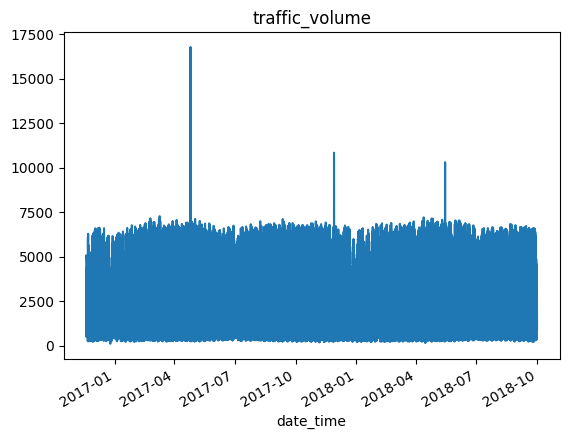

In [10]:
df['traffic_volume'].plot(title='traffic_volume')

In [11]:
df_encoded = pd.get_dummies(df)

# Calculate corr on the encoded
df_encoded.corr().loc['traffic_volume']

,traffic_volume
traffic_volume,1.000000
temp,0.132268
rain_1h,0.012803
snow_1h,NaN
clouds_all,0.094228
weather_main_Clear,-0.088036
weather_main_Clouds,0.181453
weather_main_Drizzle,0.000504
weather_main_Fog,-0.046745
weather_main_Haze,0.004766


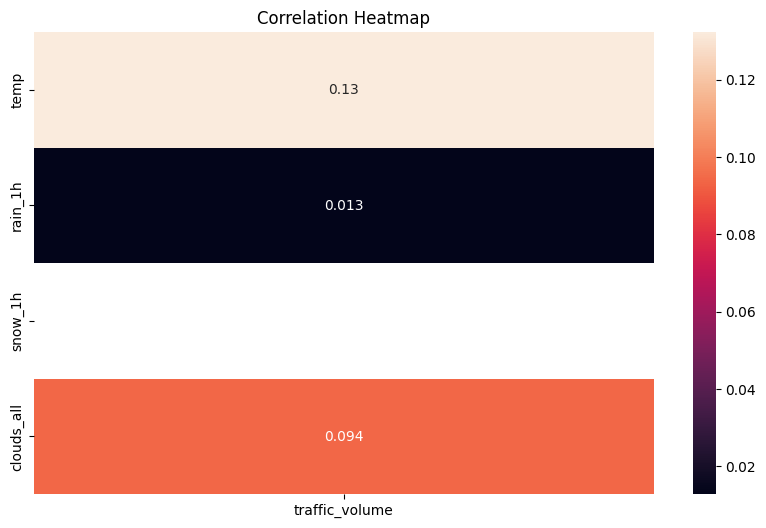

In [12]:
numerical_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(10, 6))
sns.heatmap(numerical_df.corr().loc[['traffic_volume']].drop('traffic_volume',axis=1).transpose(),annot=True)
plt.title('Correlation Heatmap')
plt.show()

In [13]:
features = ['temp','rain_1h','snow_1h','clouds_all']
target = ['traffic_volume']

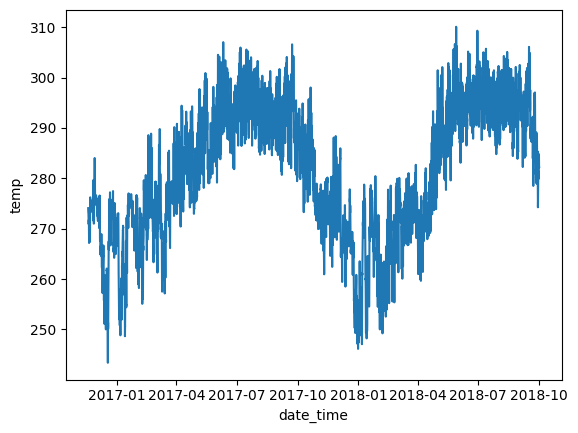

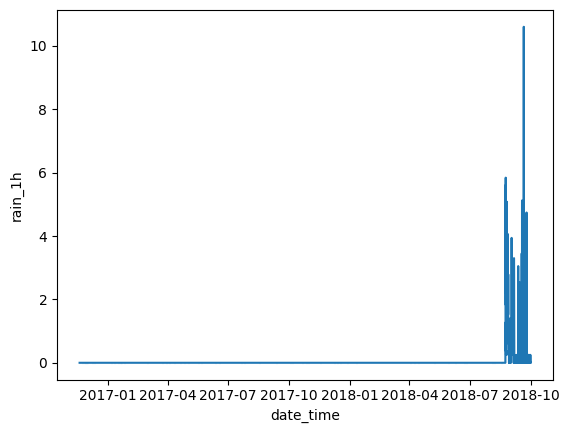

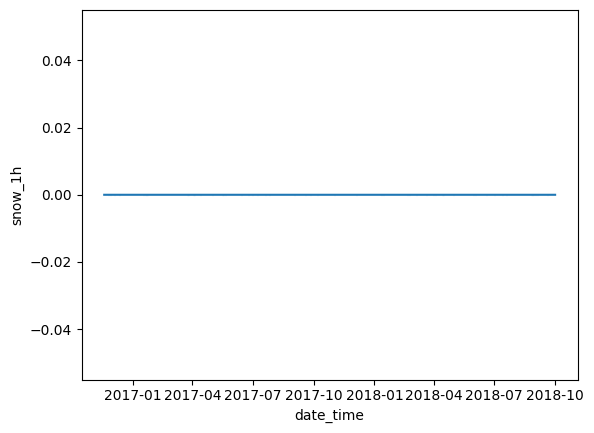

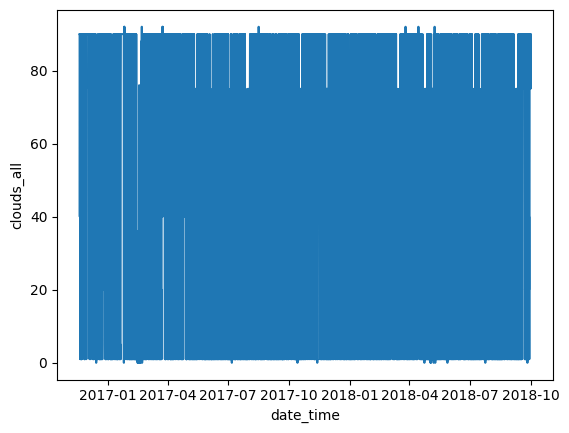

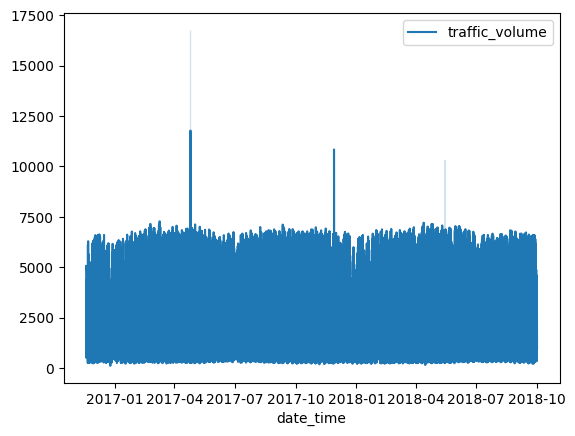

In [14]:
for feature in features:
  sns.lineplot(df[feature])
  plt.show()
sns.lineplot(df[target])
plt.show()

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [15]:
df.isna().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [16]:
df.fillna(method='bfill',inplace=True)

<ipython-input-16-71c2b11f6341>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill',inplace=True)


In [17]:
df.isna().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [18]:
from scipy.stats import zscore

imputed_series = df['traffic_volume'].copy()

window_size = 30
for i in range(window_size-window_size, len(df) - window_size, window_size):
    window = df['traffic_volume'].iloc[i - window_size:i]
    z_scores = zscore(window)

    outliers = np.where(np.abs(z_scores) > 3)[0]

    for outlier in outliers:
        imputed_series.iloc[i - window_size + outlier] = np.nan

imputed_series.ffill(inplace=True)

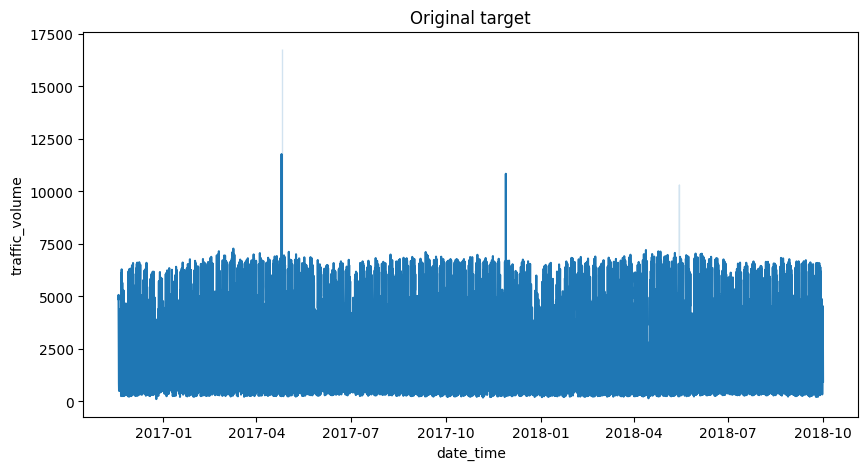

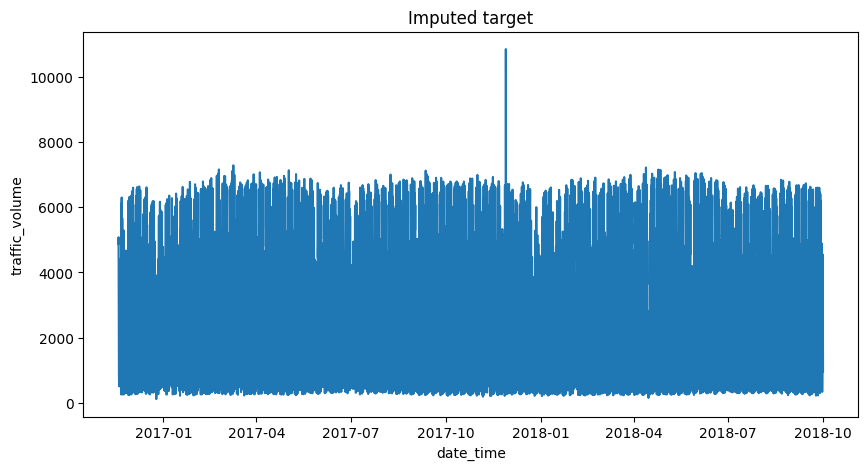

In [19]:
plt.figure(figsize=(10, 5))
sns.lineplot(df['traffic_volume'])
plt.title('Original target')
plt.show()

plt.figure(figsize=(10, 5))
sns.lineplot(imputed_series)
plt.title('Imputed target')
plt.show()

In [20]:
df['traffic_volume'] = imputed_series

In [21]:
df.shape

(20000, 7)

<Axes: xlabel='date_time'>

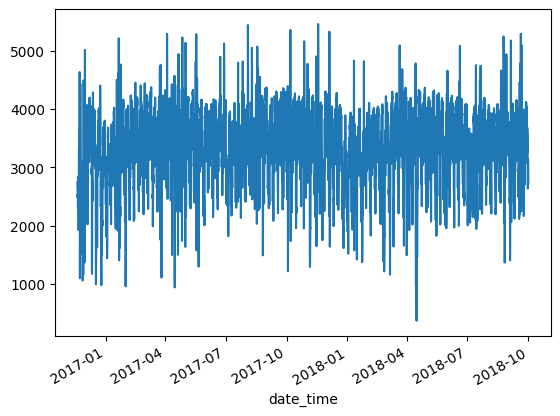

In [22]:
df['tr'] = df['traffic_volume'].rolling(window=30).mean()
df['tr'].plot()

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [23]:
df['tr'].head(30)

,tr
date_time,
2016-11-18 15:00:00,NaN
2016-11-18 15:00:00,NaN
2016-11-18 15:00:00,NaN
2016-11-18 16:00:00,NaN
2016-11-18 16:00:00,NaN
2016-11-18 16:00:00,NaN
2016-11-18 17:00:00,NaN
2016-11-18 17:00:00,NaN
2016-11-18 17:00:00,NaN


In [24]:
df.tr.isna().sum()

29

In [25]:
df.dropna(inplace=True)

In [26]:
df.shape

(19971, 8)

In [27]:
df.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all',
       'weather_main', 'weather_description', 'tr'],
      dtype='object')

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [28]:
df = df[['traffic_volume', 'tr']]

In [29]:
train_data , test_data = train_test_split(df[['traffic_volume', 'tr']] , test_size=0.3, shuffle=False)
val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False)

## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [30]:
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

train_data['traffic_volume'] = target_scaler.fit_transform(train_data[['traffic_volume']])
train_data['tr'] = feature_scaler.fit_transform(train_data[['tr']])

val_data['traffic_volume'] = target_scaler.transform(val_data[['traffic_volume']])
val_data['tr'] = feature_scaler.transform(val_data[['tr']])

test_data['traffic_volume'] = target_scaler.transform(test_data[['traffic_volume']])
test_data['tr'] = feature_scaler.transform(test_data[['tr']])

In [31]:
train_data.head()

,traffic_volume,tr
date_time,,
2016-11-19 09:00:00,0.315657,0.399109
2016-11-19 10:00:00,0.346505,0.391420
2016-11-19 11:00:00,0.388816,0.387084
2016-11-19 12:00:00,0.398509,0.383517
2016-11-19 13:00:00,0.393197,0.378036


In [32]:
train_data = train_data.values
val_data = val_data.values
test_data = test_data.values

In [33]:
win_size = 30

train_ds = timeseries_dataset_from_array(
    train_data,
    targets=train_data[win_size:,0],
    sequence_length=win_size,
    batch_size=32
)

test_ds = timeseries_dataset_from_array(
    test_data,
    targets=test_data[win_size:,0],
    sequence_length=win_size,
    batch_size=32
)

val_ds = timeseries_dataset_from_array(
    val_data,
    targets=val_data[win_size:,0],
    sequence_length=win_size,
    batch_size=32
)

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [34]:
RNN_model = Sequential()
RNN_model.add(SimpleRNN(units=50, return_sequences=True))
RNN_model.add(Dropout(0.2))
RNN_model.add(SimpleRNN(units=50))
RNN_model.add(Dropout(0.2))
RNN_model.add(Dense(units=1))
RNN_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [36]:
RNN_history = RNN_model.fit(train_ds, epochs=30, validation_data=val_ds,callbacks=early_stopping)

Epoch 1/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.0811 - mae: 0.2019 - val_loss: 0.0041 - val_mae: 0.0465
Epoch 2/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0089 - mae: 0.0732 - val_loss: 0.0032 - val_mae: 0.0415
Epoch 3/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0062 - mae: 0.0602 - val_loss: 0.0030 - val_mae: 0.0395
Epoch 4/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0053 - mae: 0.0545 - val_loss: 0.0029 - val_mae: 0.0387
Epoch 5/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.0047 - mae: 0.0508 - val_loss: 0.0030 - val_mae: 0.0398
Epoch 6/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0044 - mae: 0.0492 - val_loss: 0.0030 - val_mae: 0.0393
Epoch 7/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0042 - mae: 0.0477 - val_loss: 0.0029 - val_mae: 0.0388
Epoch 8/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0041 - mae: 0.0468 - val_loss: 0.0030 - val_mae: 0.0392
Epoch 9/30
436/436 ━━━━━━━━━━━━━━━━━━━━ 

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [37]:
rnn_predictions = RNN_model.predict(train_ds)
rnn_predictions_test = RNN_model.predict(test_ds)
rnn_predictions_val = RNN_model.predict(val_ds)

436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [38]:
rnn_predictions = target_scaler.inverse_transform(rnn_predictions)
rnn_predictions_test = target_scaler.inverse_transform(rnn_predictions_test)
rnn_predictions_val = target_scaler.inverse_transform(rnn_predictions_val)

### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [39]:
df.head()

,traffic_volume,tr
date_time,,
2016-11-19 09:00:00,3500.0,2742.300000
2016-11-19 10:00:00,3831.0,2707.600000
2016-11-19 11:00:00,4285.0,2688.033333
2016-11-19 12:00:00,4389.0,2671.933333
2016-11-19 13:00:00,4332.0,2647.200000


In [40]:
# Calc the mean absolute error between the allowed values and the predictions produced
print(f'Test MAE: {mean_absolute_error(test_data[win_size:,0], rnn_predictions_test.flatten())}')

Test MAE: 3267.0423484376824


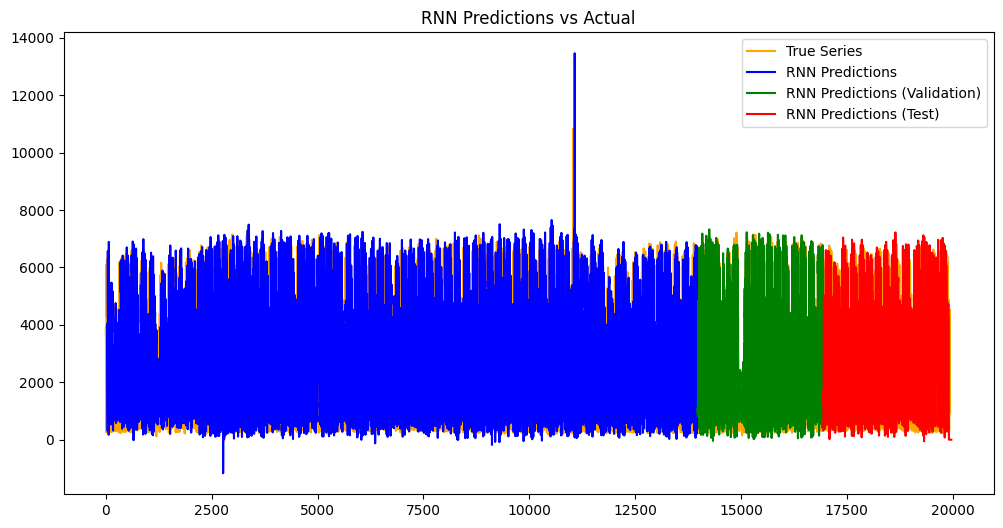

In [41]:
import matplotlib.pyplot as plt
rnn_arr = np.zeros(len(df))
rnn_arr[:win_size] = np.nan
#RNN

rnn_arr[win_size:len(rnn_predictions)+win_size] = rnn_predictions.flatten()
rnn_arr[len(rnn_predictions)+win_size:len(rnn_predictions)+len(rnn_predictions_val)+win_size] = rnn_predictions_val.flatten()
rnn_arr[len(rnn_predictions)+len(rnn_predictions_val)+win_size:len(rnn_predictions)+len(rnn_predictions_val)+len(rnn_predictions_test)+win_size] = rnn_predictions_test.flatten()

plt.figure(figsize=(12, 6))
plt.plot(df.iloc[win_size:,0].values, label='True Series',color='orange')
plt.plot(rnn_arr[:len(rnn_predictions)+win_size], label='RNN Predictions', color='blue')
plt.plot(np.arange(len(rnn_predictions)+win_size, len(rnn_predictions)+len(rnn_predictions_val)+win_size),
         rnn_arr[len(rnn_predictions)+win_size:len(rnn_predictions)+len(rnn_predictions_val)+win_size],
         label='RNN Predictions (Validation)', color='green')
plt.plot(np.arange(len(rnn_predictions)+len(rnn_predictions_val)+win_size, len(rnn_arr)),
         rnn_arr[len(rnn_predictions)+len(rnn_predictions_val)+win_size:],
         label='RNN Predictions (Test)', color='red')

plt.legend()
plt.title('RNN Predictions vs Actual')
plt.show()


### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [42]:
GRU_model = Sequential()
GRU_model.add(GRU(units=50))
GRU_model.add(Dropout(0.2))

GRU_model.add(Dense(units=1))

GRU_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [43]:
GRU_history = GRU_model.fit(train_ds, epochs=20, validation_data=val_ds,callbacks=early_stopping)

Epoch 1/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - loss: 0.0187 - mae: 0.1056 - val_loss: 0.0044 - val_mae: 0.0493
Epoch 2/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 0.0047 - mae: 0.0503 - val_loss: 0.0032 - val_mae: 0.0403
Epoch 3/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - loss: 0.0039 - mae: 0.0453 - val_loss: 0.0030 - val_mae: 0.0389


In [44]:
GRU_predictions = GRU_model.predict(train_ds)
GRU_predictions_test = GRU_model.predict(test_ds)
GRU_predictions_val = GRU_model.predict(val_ds)

436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [45]:
GRU_predictions = target_scaler.inverse_transform(GRU_predictions)
GRU_predictions_test = target_scaler.inverse_transform(GRU_predictions_test)
GRU_predictions_val = target_scaler.inverse_transform(GRU_predictions_val)

### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

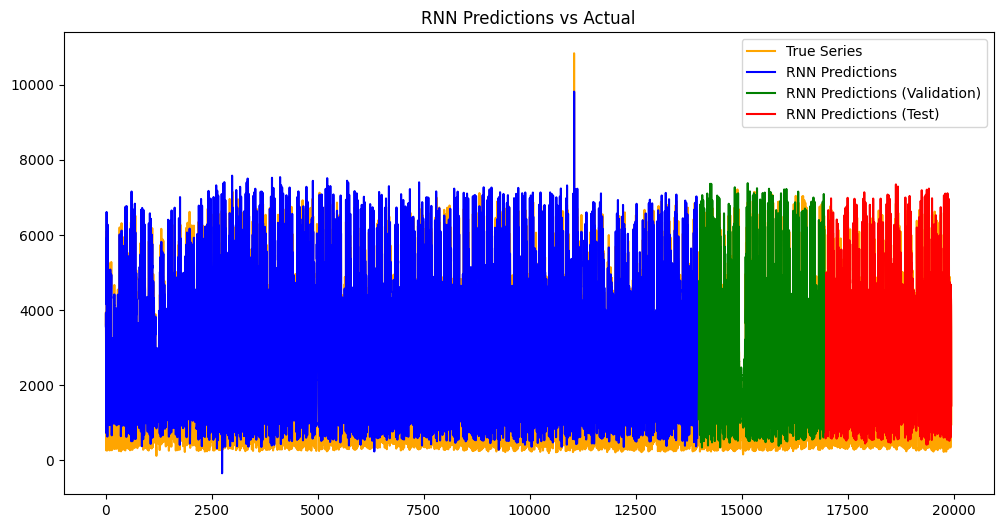

In [46]:
import matplotlib.pyplot as plt
GRU_arr = np.zeros(len(df))
GRU_arr[:win_size] = np.nan


#GRU

GRU_arr[win_size:len(GRU_predictions)+win_size] = GRU_predictions.flatten()
GRU_arr[len(GRU_predictions)+win_size:len(GRU_predictions)+len(GRU_predictions_val)+win_size] = GRU_predictions_val.flatten()
GRU_arr[len(GRU_predictions)+len(GRU_predictions_val)+win_size:len(GRU_predictions)+len(GRU_predictions_val)+len(GRU_predictions_test)+win_size] = GRU_predictions_test.flatten()

plt.figure(figsize=(12, 6))
plt.plot(df.iloc[win_size:,0].values, label='True Series',color='orange')
plt.plot(GRU_arr[win_size:len(GRU_predictions)+win_size], label='RNN Predictions', color='blue')
plt.plot(np.arange(len(GRU_predictions)+win_size, len(GRU_predictions)+len(GRU_predictions_val)+win_size),
         GRU_arr[len(GRU_predictions)+win_size:len(GRU_predictions)+len(GRU_predictions_val)+win_size],
         label='RNN Predictions (Validation)', color='green')
plt.plot(np.arange(len(GRU_predictions)+len(GRU_predictions_val)+win_size+30, len(GRU_arr)-30),
         GRU_arr[len(GRU_predictions)+len(GRU_predictions_val)+win_size:-60],
         label='RNN Predictions (Test)', color='red')

plt.legend()
plt.title('RNN Predictions vs Actual')
plt.show()

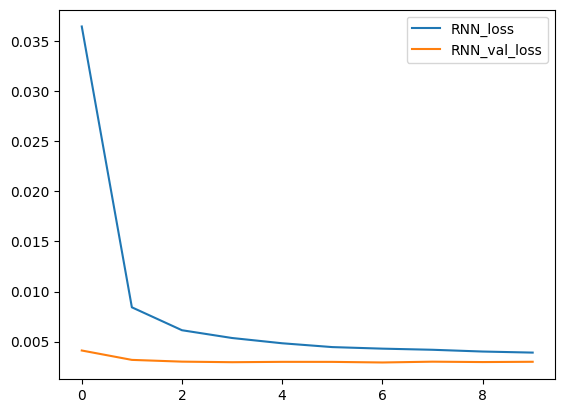

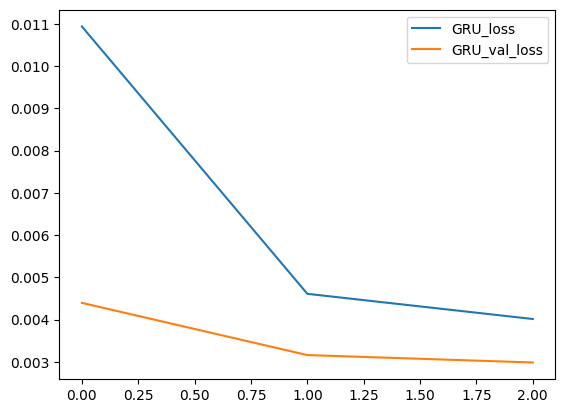

In [47]:
plt.plot(RNN_history.history['loss'],label='RNN_loss')
plt.plot(RNN_history.history['val_loss'],label='RNN_val_loss')
plt.legend()
plt.show()

plt.plot(GRU_history.history['loss'],label='GRU_loss')
plt.plot(GRU_history.history['val_loss'],label='GRU_val_loss')
plt.legend()
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

First, I read the data and then put the ['date_time'] column as an index so that it would be easier for me to deal with the data since it is a time series.
I visulaze the ['traffic_volume'] column and I don't really understand the drawing then I calculated the correlation So I can understand relationships and connections better
Then I chose the numeric variable's as a features and the target to understand the data sequence.
I dealt with missing value using method = 'bfill'
and then I Dealing with outliers by z-score & I stored it in imputed_series
I used plt for the ['traffic_volume'] and after the change ->imputed_series' to see the difference and then i stored 'imputed_series' in ['traffic_volume']
also one of the things I used to improve['traffic_volume'] rolling window calculator which it helping to discover trends and patterns in traffic volume data over time
Then i drop nan values in last column what i named ['tr']
The data was divided into 30 tests and the rest was training. Then, half of the 30 went to the validation and the rest to the test.
And targeted or i chose two columns['traffic_volume', 'tr']
in Feature Scaling i use MinMaxScaler method
i just fit train_data and val+test i just did transform on them
i use timeseries_dataset_from_array function to prepare time series data for the training and evaluation of models by mapping data to different sets (training, testing and validation)
i use RNN a GRU model first whin i buld model i choice Sequential which mean one by one and number of unit = 50 + Dropout = 0.2 so i can avoid overfitting
to measure and improve errors using MSE and MAE to evaluate performance.
and then i use EarlyStopping to avoid overtraining and improve model performance.
after making predictions, I need to return the values ​​to their original range to properly analyze the results and compare them to the actual values by use inverse_transform

### Answer Here: